In [13]:
# import methods

from methods import plot3d
from methods import bin_spatial
from methods import color_hist
from methods import get_hog_features
# from methods import extract_features
from methods import slide_window

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

# Import everything needed to edit/save/watch video clips

from IPython.display import HTML
from moviepy.editor import VideoFileClip

# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

In [16]:
## General Settings

# settings for colorspace feature extraction
cspace_val = 'RGB'#'RGB'
spatial_size_val = (32, 32)

# settings for histogram feature extraction
hist_bins_val = 32
hist_range_val = (0,256)

# settings for hog feature extraction
orient_val = 9
pix_per_cell_val = 8
cell_per_block_val = 2
# orient_val = 12
# pix_per_cell_val = 16
# cell_per_block_val = 4
hog_channel_val = 2

In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# this function combines color, histogram and hog features extraction
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file) # reads a file into bgr values 0-255
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: 
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to rgb
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(np.concatenate(( hist_features, hog_features)))
        
    # Return list of feature vectors
    return features

In [18]:
# crop image to a given region of interes defined by the vertices
def region_of_interest(img, vertices, color_max_value = 255):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (color_max_value,) * channel_count
    else:
        ignore_mask_color = color_max_value
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Method
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Combined Color, Histogram and HOG Classification

In [19]:
 # Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

cars = []
notcars = []

# load vehicle images
images = glob.iglob('vehicles/**/*.png', recursive=True)
for image in images:
    cars.append(image)
    
# load non vehicle images
images = glob.iglob('non-vehicles/**/*.png', recursive=True)
for image in images:
    notcars.append(image)

print('cars = ',len(cars))
print('notcars = ',len(notcars))

# experiment other color spaces like LUV, HLS

car_features = extract_features(cars, cspace=cspace_val, spatial_size=spatial_size_val,
                        hist_bins=hist_bins_val, hist_range=hist_range_val, orient=orient_val, 
                        pix_per_cell=pix_per_cell_val, cell_per_block=cell_per_block_val, hog_channel=hog_channel_val)

print("Car features extracted")

notcar_features = extract_features(notcars, cspace=cspace_val, spatial_size=spatial_size_val,
                        hist_bins=hist_bins_val, hist_range=hist_range_val, orient=orient_val, 
                        pix_per_cell=pix_per_cell_val, cell_per_block=cell_per_block_val, hog_channel=hog_channel_val)

print("Other features extracted")


cars =  8792
notcars =  9666
Car features extracted
Other features extracted


In [20]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print("X_scaler ready")

X_scaler ready


In [21]:
#save the model
joblib.dump(X_scaler, 'X_scaler_model.pkl')

['X_scaler_model.pkl']

In [22]:
# Apply the scaler to X - normalise data
scaled_X = X_scaler.transform(X)
print("Data normalised")

Data normalised


In [23]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
print("prediction",prediction)
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

# RGB test accuracy = 0.9788 and low number of false positives in test images
# HSV test accuracy = 0.9777 but lots of false positives
# HLS test accuracy = 0.9688 but lots of false positives
# LUV test accuracy = 0.984  but lots of false positives
# YUV test accuracy = 0.9786 but lots of false positives  

5.320061206817627 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.979956663055
prediction [ 1.]
0.0007727146148681641 Seconds to predict with SVC


In [24]:
print(svc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [26]:
# save the model
joblib.dump(svc, 'svc_model.pkl')


['svc_model.pkl']

# ---------------------------------
# LOAD the Models
# ---------------------------------

'svc_model.pkl'

'X_scaler_model.pkl'

In [27]:
# load the model
svc = joblib.load('svc_model.pkl')
X_scaler = joblib.load('X_scaler_model.pkl')
print("Model loaded: \n\n",svc)

Model loaded: 

 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


# Sliding Window Implementation

In [28]:
def draw_rectangles(img,window_list,color= (255,255,255)):
    labeled_img = img.copy()
    for window in window_list:
        pt1 = window[0]
        pt2 = window[1]
        thickness = 4
        cv2.rectangle(labeled_img, pt1, pt2, color, thickness)
    return labeled_img

In [29]:
# create a list of rectangles with different sizes across the lower part of the image for searching cars
def create_list_rectangles(img,overlap = 0.75):
    
    height, width, channels = img.shape
#     print('height, width, channels = ',height, width, channels)
    window_list=();
    rectangles = []

    step_h = 32
    start_h = step_h#int(height/4)
    stop_h = height 
    size_of_sq = int(256 * (1/height))
    original_y_val = int(9*height/16) #int(6*height/11)
    # original_y_val = int(6*height/12)
    y_val = original_y_val    

    size_vec = [64, 96, 128, 160]
    overlap_vec = [0, 0.5, 0.65, 0.8]
    # size_vec = [160]
    # overlap_vec = [0.8]
    for i in range(len(size_vec)):
        size = size_vec[i]
        overlap = overlap_vec[i]
        window_list = slide_window(img, x_start_stop=[0, width+size], y_start_stop=[y_val,y_val+4*size], 
                        xy_window=(size, size), xy_overlap=(overlap,overlap),max_y=height*0.9)
        rectangles.extend(window_list)
    return rectangles

In [79]:
# Create the heat map
def get_heat_map(img,cspace_val,rectangles,spatial_size_val,hist_bins_val,
                hist_range_val,hog_channel_val,orient_val,pix_per_cell_val,cell_per_block_val):
    
    heat_increment = 40
    CV_FILLED = -1
    heat_map = np.zeros_like(img)
    if cspace_val != 'RGB':
        if cspace_val == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif cspace_val == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif cspace_val == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif cspace_val == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    else: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb
        feature_image = np.copy(img)     

    for rectangle in rectangles:
        heat_img = np.zeros_like(img)
        pt1 = rectangle[0]
        pt2 = rectangle[1]
        crop_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        size = (64,64)
        crop_img = cv2.resize(crop_img, size)

        img_features =[]
#         spatial_features = bin_spatial(crop_img, size=spatial_size_val)
        hist_features = color_hist(crop_img, nbins=hist_bins_val, bins_range=hist_range_val)
        hog_features = get_hog_features(crop_img[:,:,hog_channel_val], orient=orient_val, 
                        pix_per_cell=pix_per_cell_val, cell_per_block=cell_per_block_val, vis=False, feature_vec=True)

#         img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        img_features.append(np.concatenate(( hist_features, hog_features)))
        X = np.vstack((img_features)).astype(np.float64)
        X = np.array(X).reshape(1, -1)

        scaled_X = X_scaler.transform(X)
        prediction = svc.predict(scaled_X.reshape(1, -1))
        if prediction == 1:
            cv2.rectangle(heat_img, pt1, pt2, color=(heat_increment,0,0), thickness=CV_FILLED)
            heat_map = cv2.add(heat_map, heat_img)
    return heat_map

In [80]:
# apply filter to the heat_map
# Note: th_ratio should be a ratio (0-1)
# It will be used with respect to the maximum pixel value in the image
def filter_heat_map(heat_map, th_ratio=0.5):
    red_channel = np.copy(heat_map[:,:,0])
#     print("max:",np.amax(red_channel))
    th = np.amax(red_channel)*th_ratio # define threshold
#     print("th:",th)
    filt_heat_map = np.zeros_like(heat_map)
    if np.amax(red_channel)>0:
        red_channel[red_channel>=th]=255
        red_channel[red_channel<th]=0
        filt_heat_map[:,:,0]=red_channel
    return filt_heat_map

In [111]:
# computes positions and bounding rectangles identifying the location of detected vehicles
def get_detected(heat_map,area_th = 20):
     # define a threshold for minimum area required to be a positive detection
    imgray = heat_map[:,:,0]#cv2.cvtColor(heat_map,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray.astype(np.uint8),130,255,cv2.THRESH_BINARY)
    
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#     im2, contours, hierarchy = cv2.findContours(heat_map[:,:,0],cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    detected_car_pos = [];
    detected_car_rectangles = [];
    for contour in contours:
        area = cv2.contourArea(contour)
#         print(area)
        if area>area_th:
            x,y,w,h = cv2.boundingRect(contour)
            M = cv2.moments(contour)
            # calculate image centroid
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            pt1 = (x,y)
            pt2 = (x+w,y+h)
            detected_car_pos.append([cx,cy])
            detected_car_rectangles.append([pt1,pt2])
    return detected_car_pos,detected_car_rectangles

In [121]:
def process_image(img,debug=0):
    
    ################################################################################
    #these settings have to be made global or loaded via other way
    cspace_val = 'RGB'#'RGB'
    spatial_size_val = (32, 32)

    # settings for histogram feature extraction
    hist_bins_val = 32
    hist_range_val = (0,256)

    # settings for hog feature extraction
    orient_val = 9
    pix_per_cell_val = 8
    cell_per_block_val = 2
    # orient_val = 12
    # pix_per_cell_val = 16
    # cell_per_block_val = 4
    hog_channel_val = 2
    #################################################################################
    
    if not hasattr(process_image, "heat_map_old"):
        process_image.heat_map_old = np.zeros_like(img)
    
    if not process_image.heat_map_old.size:
        process_image.heat_map_old = np.zeros_like(img)
    
    decay = 0.2
    # apply decay to the heat_map
    process_image.heat_map_old = process_image.heat_map_old*(1-decay)
    
    rectangles = create_list_rectangles(img,overlap = 0.5)

    heat_map = get_heat_map(img,cspace_val,rectangles,spatial_size_val,hist_bins_val,
                    hist_range_val,hog_channel_val,orient_val,pix_per_cell_val,cell_per_block_val)
    
    filtered_heat_map = filter_heat_map(heat_map,th_ratio=0.1)
    
    process_image.heat_map_old = (filtered_heat_map*0.5 + process_image.heat_map_old*0.5)

    detected_car_pos,detected_car_rectangles = get_detected(process_image.heat_map_old,area_th = 1000)
    
    detected_cars_img = draw_rectangles(img,detected_car_rectangles,color= (255,255,255))
    if debug:
        # Ploting images
        labeled_img = draw_rectangles(img,rectangles)

        fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
        fig.tight_layout();
        

        ax1.imshow(heat_map)
        ax1.set_title('Heat map')
        ax2.imshow(filtered_heat_map.astype(np.uint8))
        ax2.set_title('Filtered heat_map')
        ax3.imshow(process_image.heat_map_old.astype(np.uint8))
        ax3.set_title('Used heat_map')
        ax4.imshow(img)
        ax4.set_title('Source image')
        ax5.imshow(labeled_img)
        ax5.set_title('Positive cars')
        ax6.imshow(detected_cars_img)
        ax6.set_title('Confirmed cars')
        ax1.axis('off');
        ax2.axis('off');
        ax3.axis('off');
        ax4.axis('off');
        ax5.axis('off');
        ax6.axis('off');
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);
        plt.show();
        
    return detected_cars_img
#     if not hasattr(process_image, "count"):
#         process_image.left_sp_avg = int(-100000)
#         process_image.right_sp_avg = int(-100000)
#         process_image.count = 0

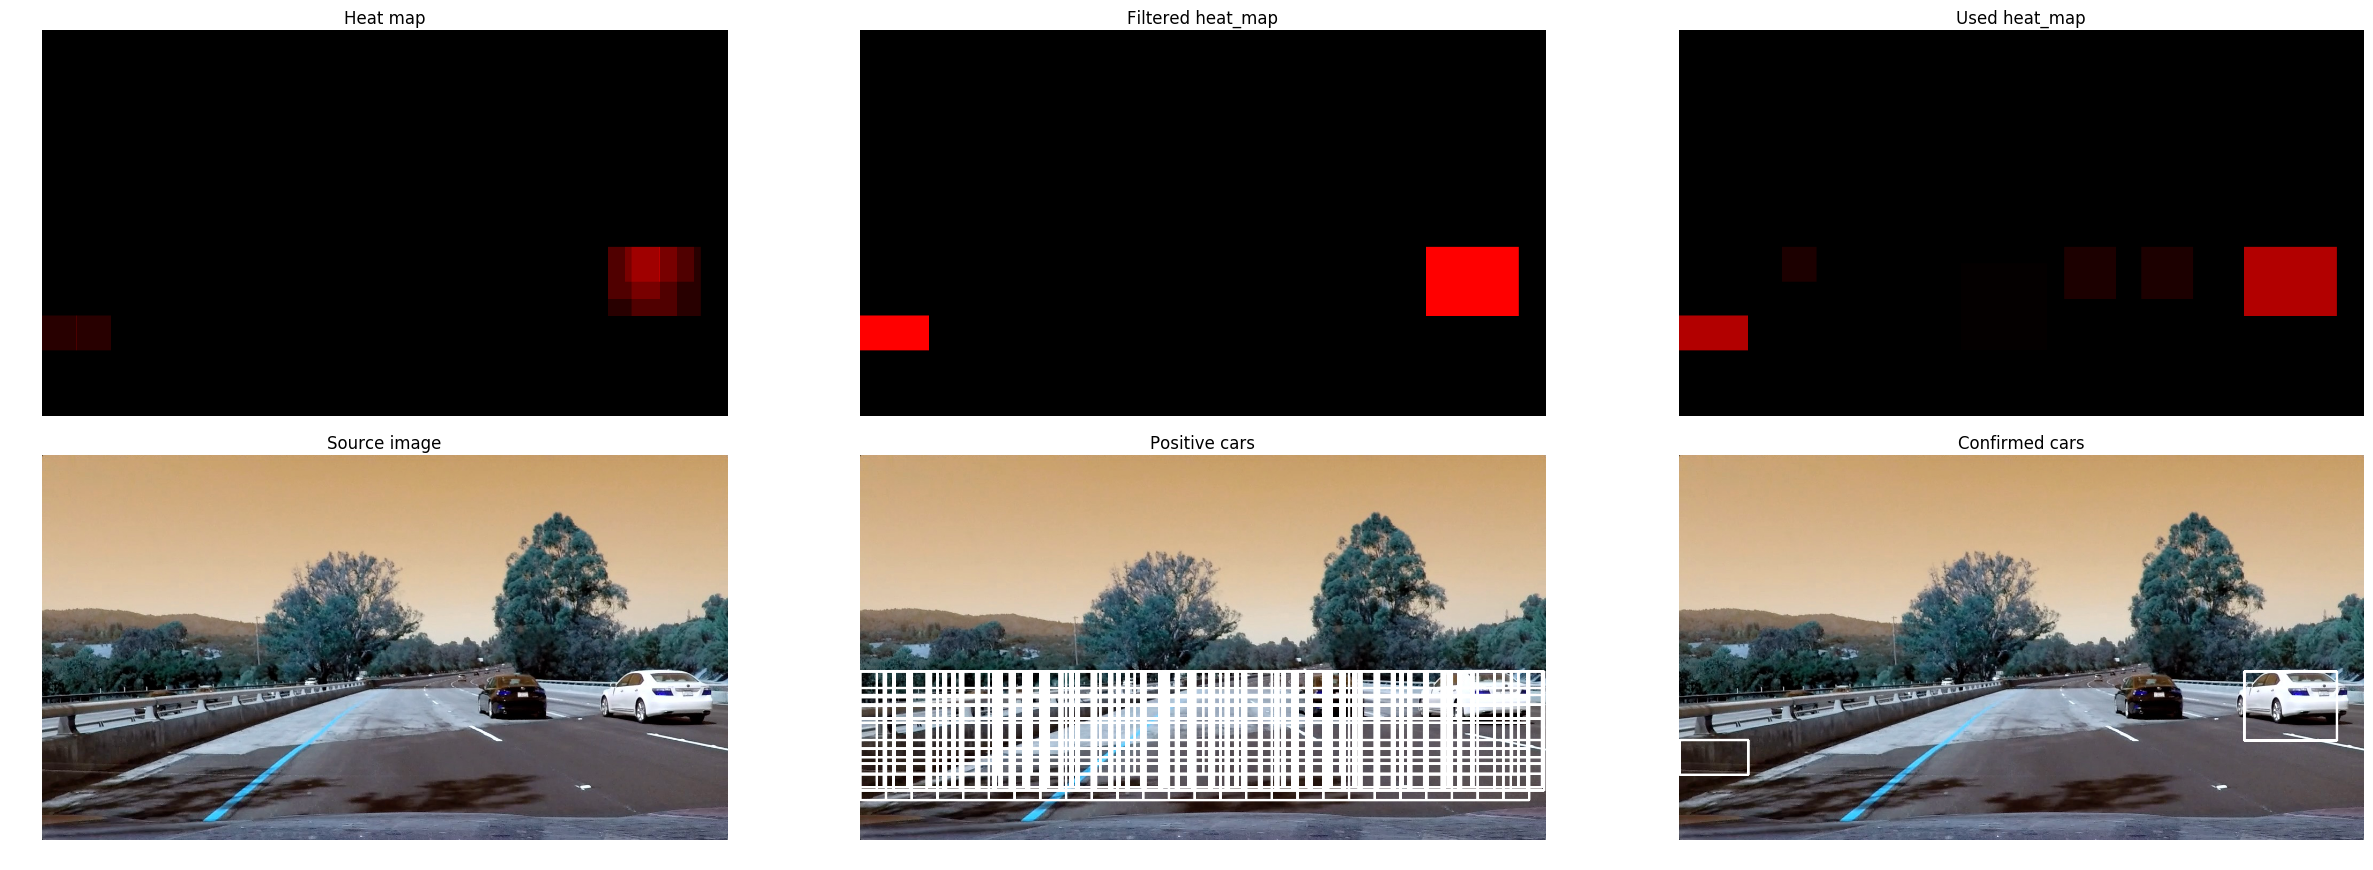

In [132]:
# pipeline
# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
img = cv2.imread('test_images/test6.jpg') # two cars, black and white
img = cv2.imread('test_images/test5.jpg') # two cars, black and white
img = cv2.imread('test_images/test4.jpg') # two cars, black and white
# img = cv2.imread('test_images/test3.jpg') # white car
# img = cv2.imread('test_images/test2.jpg') # no cars
# img = cv2.imread('test_images/test1.jpg') # two cars, black and white
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
process_image(img,debug=1);

In [133]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(img)

In [134]:
# get an image from video and plug it in the pipeline
# the pipeline should accept a 

In [135]:
video_output = 'small_video_output.mp4';
clip1 = VideoFileClip("small_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video small_video_output.mp4
[MoviePy] Writing video small_video_output.mp4


100%|█████████▉| 304/305 [05:07<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: small_video_output.mp4 

CPU times: user 5min 36s, sys: 603 ms, total: 5min 37s
Wall time: 5min 7s
Finished processing video file


In [ ]:
# initialise static variables
process_image.left_sp_avg = -10000
process_image.right_sp_avg = -10000
process_image.count = 0